In [10]:
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))


# Load Dataset

In [81]:
import pandas as pd
import numpy as np
from IPython.display import display_html 

trainDf = pd.read_csv('train.csv')
testDf = pd.read_csv('test.csv')

trainDf.shape, testDf.shape

((159571, 8), (153164, 2))

In [82]:
display(trainDf.head(3))
display(testDf.head(3))

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."


In [83]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# EDA

- Check NaNs

In [84]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=trainDf.columns, y=np.sum(trainDf.isna().values, axis=0))])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Missing values')
fig.show()

- Check Duplicates

In [85]:
trainDf.duplicated().sum()

0

- Check Dataset Balancing

In [86]:
values = [trainDf[i].value_counts()[1] for i in trainDf.columns[2:]]
labels = trainDf.columns[2:]
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'black']

In [88]:
trainDf.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [17]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2,specs=[[{"type": "domain"}, {"type": "xy"}]])

fig.add_trace(
    go.Pie(labels=labels, values=values, textinfo='label+percent'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=labels, y=values, marker_color=colors),
    row=1, col=2
)



fig.update_layout(title_text="Target Distribution in Dataset" ,showlegend=False,)
fig.show()

- Lengths of comments

average length of comment: 394.073


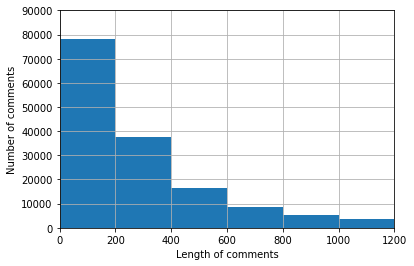

In [18]:
import matplotlib.pyplot as plt
x = [len(trainDf['comment_text'][i]) for i in range(trainDf['comment_text'].shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

- show samples of data texts to find out required preprocessing steps

In [19]:
toxicDF = trainDf[trainDf.toxic==1] 
severe_toxicDf = trainDf[trainDf.severe_toxic==1] 
obsceneDF = trainDf[trainDf.obscene==1] 
threatDf = trainDf[trainDf.threat==1] 
insultDF = trainDf[trainDf.insult==1] 
identity_hateDf = trainDf[trainDf.identity_hate==1] 

print('***** toxic ***** \n')
print(toxicDF.comment_text.iloc[13])
print(toxicDF.comment_text.iloc[5])


print('\n***** severe_toxic ***** \n')
print(severe_toxicDf.comment_text.iloc[13])
print(severe_toxicDf.comment_text.iloc[5])


print('\n***** obscene ***** \n')
print(obsceneDF.comment_text.iloc[13])
print(obsceneDF.comment_text.iloc[5])

print('\n***** threat ***** \n')
print(threatDf.comment_text.iloc[13])
print(threatDf.comment_text.iloc[5])

print('\n***** insult ***** \n')
print(insultDF.comment_text.iloc[13])
print(insultDF.comment_text.iloc[5])

print('\n***** identity_hate ***** \n')
print(identity_hateDf.comment_text.iloc[13])
print(identity_hateDf.comment_text.iloc[5])

***** toxic ***** 

Would you both shut up, you don't run wikipedia, especially a stupid kid.
I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82

***** severe_toxic ***** 

Fuck you people. The information of that can be found here []
"You know, I was thinking...

Nobody really attacked me before I revealed my age here.  After I announced that I was 14, I was subject to a constant storm of harassment and abuse.

The same thing goes for when I was on The Sandbox when I was 11.  Before people knew my age, they didn't care.  After I told them my age, they hated me.

It's just so amusing how the idiot Soapboxers think of teenagers as being responsible for the ""decline"" of The Soapbox (like it was ever any good to begin with

### Cleaning and Preprocessing are:
    - 1 Remove numbers from all comments
    - 2 Remove unchars word
    - 3 Check for emails
    - 4 Check for websites ( http...)
    - 5 Normalizing

- Remove numbers from all comments

In [20]:
import re
dfTrainModified = trainDf.copy()

dfTrainModified['comment_text']=dfTrainModified['comment_text'].apply(lambda x: re.sub('\d+','', x))
dfTrainModified.comment_text[0], trainDf.comment_text[0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now....",
 "Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27")

- Check for websites ( http...)

In [21]:
trainDf.comment_text.apply(lambda x: re.findall('https?://\S+|www\.\S+',x))

0         []
1         []
2         []
3         []
4         []
          ..
159566    []
159567    []
159568    []
159569    []
159570    []
Name: comment_text, Length: 159571, dtype: object

- Remove unchars word

In [22]:
dfTrainModified['comment_text'] = dfTrainModified['comment_text'].apply(lambda x: re.sub('[^A-Za-z]',' ',x))
dfTrainModified.comment_text[5], trainDf.comment_text[5]

('   Congratulations from me as well  use the tools well     talk  ',
 '"\n\nCongratulations from me as well, use the tools well. \xa0· talk "')

- Check for emails

In [23]:
result=0
for i in range(len(dfTrainModified)):
    if re.findall(r'\S+@(\S+)', dfTrainModified.comment_text[i]):
        result +=1
print(result)

0


## Normalizing

- Lower all words

In [24]:
dfTrainModified['comment_text']=dfTrainModified['comment_text'].apply(lambda x: x.lower())
dfTrainModified.comment_text[7], trainDf.comment_text[7]

('your vandalism to the matt shirvington article has been reverted   please don t do it again  or you will be banned ',
 "Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned.")

- Remove stopwords

In [25]:
import nltk 
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words=stopwords.words('english')

dfTrainModified['comment_text']=dfTrainModified['comment_text'].\
                                apply(lambda x : [word for word in x.split()  if word not in stop_words])

In [26]:
dfTrainModified.comment_text[4], trainDf.comment_text[4]

(['sir', 'hero', 'chance', 'remember', 'page'],
 "You, sir, are my hero. Any chance you remember what page that's on?")

- Lemmatization

In [27]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

dfTrainModified['comment_text']=dfTrainModified['comment_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [28]:
dfTrainModified.comment_text[233], trainDf.comment_text[233]

(['fatima',
  'bint',
  'asad',
  'noticed',
  'added',
  'large',
  'chunk',
  'article',
  'recently',
  'could',
  'post',
  'source',
  'webpage',
  'book',
  'etc',
  'would',
  'really',
  'helpful',
  'thanks',
  'july',
  'utc'],
 'Fatima bint Asad \nI noticed you added a large chunk to this article recently. Could you post your sources (webpages, books, etc.)? It would be really helpful. Thanks.  23:56, July 29, 2005 (UTC)')

- Change each row of the comments from list into a single string

In [29]:
dfTrainModified['comment_text']=dfTrainModified['comment_text'].apply(lambda x: ' '.join(x))

In [30]:
dfTrainModified.comment_text[233], trainDf.comment_text[233]

('fatima bint asad noticed added large chunk article recently could post source webpage book etc would really helpful thanks july utc',
 'Fatima bint Asad \nI noticed you added a large chunk to this article recently. Could you post your sources (webpages, books, etc.)? It would be really helpful. Thanks.  23:56, July 29, 2005 (UTC)')

- Preprocessing Pipline Function

In [31]:
def preprocessPipline(data, labelName):
    
    dataTemp = data.copy()
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('\d+','', x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('[^A-Za-z]',' ',x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: x.lower())
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x : [word for word in x.split()  if word not in stop_words])
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: ' '.join(x))
    return dataTemp

In [32]:
display(dfTrainModified.comment_text[2])
display(preprocessPipline(trainDf, 'comment_text').comment_text[2])
display(trainDf.comment_text[2])

'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info'

'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info'

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

average length of comment: 243.265


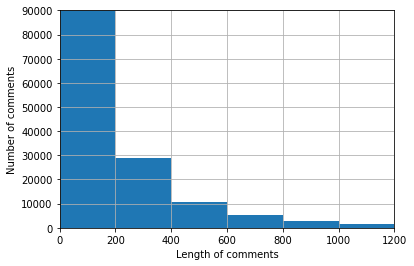

In [33]:
import matplotlib.pyplot as plt
x = [len(dfTrainModified['comment_text'][i]) for i in range(dfTrainModified['comment_text'].shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

## Bag Of Words

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(max_features=10000,ngram_range=(1,2))
vectorizer.fit(dfTrainModified['comment_text'].tolist())
x = vectorizer.transform(dfTrainModified['comment_text'].tolist())
columns = vectorizer.get_feature_names()
finalDF = pd.DataFrame(x.todense(), columns=columns, index=dfTrainModified['comment_text'].tolist())

finalDF.head()

C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,aaron,ab,abandoned,abbreviation,abc,abide,ability,able,able edit,...,yr,ytmnd,ytmnd name,yugoslav,yugoslavia,yup,zealand,zero,zionist,zone
explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aww match background colour seemingly stuck thanks talk january utc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipedia good article nomination transport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sir hero chance remember page,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
label = trainDf[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']] 
Y_data = np.asarray(label.values).astype('float32')

from sklearn.model_selection import train_test_split
x_train, x_val ,y_train ,y_val = train_test_split(finalDF,Y_data,test_size=0.1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((143613, 10000), (15958, 10000), (143613, 6), (15958, 6))

### Standard Neural Network

In [36]:
import tensorflow as tf
from keras import layers,models


model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 642,342
Trainable params: 642,342
Non-trainable params: 0
_________________________________________________________________


In [37]:
x_trainArr = np.asarray(x_train)
x_valArr = np.asarray(x_val)

In [38]:
import keras 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses

model.compile(optimizer= 'adam',
              loss= losses.binary_crossentropy,
              metrics=['AUC'])

history = model.fit(x_trainArr,y_train,epochs=10,validation_data=(x_valArr,y_val))


Epoch 1/10
4488/4488 [==============================] - 24s 5ms/step - loss: 0.0809 - auc: 0.9555 - val_loss: 0.0574 - val_auc: 0.9760
Epoch 2/10
4488/4488 [==============================] - 19s 4ms/step - loss: 0.0476 - auc: 0.9834 - val_loss: 0.0589 - val_auc: 0.9692
Epoch 3/10
4488/4488 [==============================] - 20s 4ms/step - loss: 0.0379 - auc: 0.9899 - val_loss: 0.0632 - val_auc: 0.9646
Epoch 4/10
4488/4488 [==============================] - 19s 4ms/step - loss: 0.0310 - auc: 0.9931 - val_loss: 0.0759 - val_auc: 0.9525
Epoch 5/10
4488/4488 [==============================] - 18s 4ms/step - loss: 0.0261 - auc: 0.9954 - val_loss: 0.0862 - val_auc: 0.9422
Epoch 6/10
4488/4488 [==============================] - 17s 4ms/step - loss: 0.0213 - auc: 0.9963 - val_loss: 0.1002 - val_auc: 0.9315
Epoch 7/10
4488/4488 [==============================] - 20s 5ms/step - loss: 0.0173 - auc: 0.9971 - val_loss: 0.1119 - val_auc: 0.9243
Epoch 8/10
4488/4488 [==============================] -

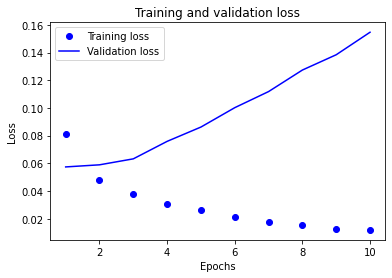

In [39]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

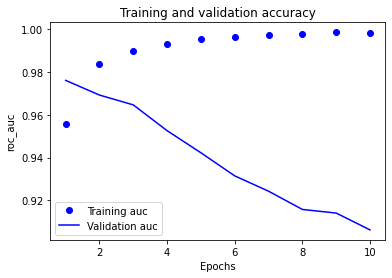

In [40]:
plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

## Preparing for LSTM

- Check various lengths of comments

In [41]:
commentLength = {}

for i in dfTrainModified.comment_text.apply(lambda x:x.split()):
    
    if '{}'.format(len(i)) in commentLength.keys():
        
        commentLength['{}'.format(len(i))] += 1
    else:
        commentLength['{}'.format(len(i))] = 1


In [42]:
commentLengthDf = pd.DataFrame.from_dict(commentLength, orient='index').reset_index()
commentLengthDf = commentLengthDf.rename(columns={'index': 'commentLen', 0: 'freq'})
commentLengthDf['commentLen'] = pd.to_numeric(commentLengthDf['commentLen'])

commentLengthDf.head()

,commentLen,freq
0,23,2487
1,10,5114
2,21,2737
3,52,684
4,5,6328


In [43]:
import plotly.express as px
fig = px.bar(commentLengthDf.sort_values('commentLen'), x='commentLen', y='freq')
fig.show()

In [44]:
# since the longest tweet length is not very long(23) I wont make padding and lets see what will happen
maxTweetLen = 70


In [45]:
processedDf = preprocessPipline(trainDf, 'comment_text')
processedDf.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww match background colour seemingly stuck th...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token="unk")
tokenizer.fit_on_texts(processedDf.comment_text)
tokenizer_seq = tokenizer.texts_to_sequences(processedDf.comment_text)


In [74]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_padded = pad_sequences(tokenizer_seq, maxlen=maxTweetLen, padding='post',truncating='post')
tokenizer_padded

array([[  467,    56,    58, ...,     0,     0,     0],
       [76800,   965,   423, ...,     0,     0,     0],
       [  291,   300,    62, ...,     0,     0,     0],
       ...,
       [76800, 76800,  4473, ...,     0,     0,     0],
       [   49,     9,   126, ...,     0,     0,     0],
       [   62,    12,   159, ...,     0,     0,     0]])

In [75]:
tokenizer_padded[2]

array([ 291,  300,   62,  152,   18,  164,  240, 1983,  378,  387,   33,
        476,   56,  253,    5,    3,  123,  279, 2078,  601,  344,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [76]:
vocab_size = len(tokenizer.word_index)
vocab_size

159052

In [77]:
label = processedDf[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']] 
Y_data = np.asarray(label.values).astype('float32')

from sklearn.model_selection import train_test_split
x_train, x_val ,y_train ,y_val = train_test_split(tokenizer_padded, Y_data, test_size=0.1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((143613, 70), (15958, 70), (143613, 6), (15958, 6))

## LSTM

In [78]:
model_lstm = models.Sequential()
model_lstm.add(layers.Embedding(5000, 300))
model_lstm.add(layers.LSTM(64))
model_lstm.add(layers.Dense(6, activation='sigmoid'))


In [79]:
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['AUC'])
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 300)         1500000   
                                                                 
 lstm_8 (LSTM)               (None, 64)                93440     
                                                                 
 dense_11 (Dense)            (None, 6)                 390       
                                                                 
Total params: 1,593,830
Trainable params: 1,593,830
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model_lstm.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_9/embedding_8/embedding_lookup' defined at (most recent call last):
    File "C:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "C:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ali\AppData\Local\Temp\ipykernel_13916\3051572589.py", line 1, in <cell line: 1>
      history = model_lstm.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ali\AppData\Roaming\Python\Python310\site-packages\keras\layers\core\embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_9/embedding_8/embedding_lookup'
indices[10,16] = 76800 is not in [0, 5000)
	 [[{{node sequential_9/embedding_8/embedding_lookup}}]] [Op:__inference_train_function_228598]

In [ ]:
import matplotlib.pyplot as plt 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
f1 = history.history['f1_m']
valF1 = history.history['val_f1_m']

plt.plot(epochs, f1, 'bo', label='Training f1')
plt.plot(epochs, valF1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()
plt.grid()
plt.show()